In [140]:
import csv
import argparse
import pandas as pd
import numpy as np
import re
import string
import os
import statistics
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
    
TRAIN = '../data/train/training_data.csv'
train_data = pd.read_csv(TRAIN, index_col=1)
dev_data = pd.read_csv('../data/dev/development_data.csv', index_col=1)

tweets = train_data[['tweet']]

In [141]:
bad_words_set = set(open("bad-words.txt").read().split())
words_set = set(open("allwords.txt").read().split())
words_set = set(item.lower() for item in words_set)

## Features

Unigrams for the data splitting on spaces

In [142]:
def get_unigrams():
    unigrams = Counter()
    for row_index, row in tweets.iterrows():
        s = row['tweet'].split()
        for word in s:
            unigrams[word] += 1
    return unigrams

### Load Emoji Dict


In [143]:
# loading the emoji dataset
def make_emoji_dict():
    emoji_dict = {}
    with open("emoji_image_to_whatIs.txt", 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.strip().split('\t')
            emoji_dict[tokens[0]] = tokens[1]
    return emoji_dict
emoji_dict = make_emoji_dict()
#emoji_dict

In [144]:
#split into quartiles?
def find_quartile_values(counts):
    counts.sort()
    first = np.quantile(counts, .25)
    second = np.quantile(counts, .5)
    third = np.quantile(counts, .75)
    return [first, second, third] 

### Emoji Sentiment Features

Emoji sentiment dictionary

Features:
Negative Sentiment,
Neutral Sentiment,
Positive Sentiment,
Overall Sentiment

In [145]:
# loading the emoji dataset
def load_emoji_sentiment_dict():
    emoji_sentiment_dict = {}
    with open("emoji_image_sentimentScore_definition_category.txt", 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.strip().split('\t')
            #each emoji has a list of 5 terms for a value
            #emoji_sentiment_dict[tokens[0]] = [('neg':tokens[1]), ('neutral':tokens[2]), ('positive':tokens[3]), ('sentiment score':tokens[4]), ('name':tokens[5]), ('category':tokens[6])]
            emoji_sentiment_dict[tokens[0]] = [tokens[1], tokens[2], tokens[3], tokens[4], tokens[5], tokens[6]]
    return emoji_sentiment_dict
emoji_sentiment_dict = load_emoji_sentiment_dict()


## Cite

Emoji	Neg[0...1]	Neut[0...1]	Pos[0...1]	Sentiment score[-1...+1]	Unicode name	Unicode block

@article{Kralj2015emojis,
  author={{Kralj Novak}, Petra and Smailovi{\'c}, Jasmina and Sluban, Borut and Mozeti\v{c}, Igor},
  title={Sentiment of emojis},
  journal={PLoS ONE},
  volume={10},
  number={12},
  pages={e0144296},
  url={http://dx.doi.org/10.1371/journal.pone.0144296},
  year={2015}
}


In [146]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [147]:
negativeValues = []
def make_emoji_negative_sentiment_bins():
    for row_index, row in tweets.iterrows():
        s = tknzr.tokenize(row['tweet'])
        score = 0
        for word in s:
            if word in emoji_sentiment_dict:
                #negative  
                score += float(emoji_sentiment_dict[word][0])
                negativeValues.append(score)
    return find_quartile_values(negativeValues)

In [148]:
# get emoji counts for data
def negative_sentiment_emojis(tweet):
    s = tknzr.tokenize(tweet)
    check = False
    emojis = []
    score = 0
    for word in s:
        if word in emoji_sentiment_dict:
            check = True
            emojis.append(word)
    if check:
        for emoji in emojis:
            num = emoji_sentiment_dict[emoji][0]
            if type(num) is not str:
                score += float(num)
    return score

In [149]:
neutralValues = []

def make_emoji_neutral_sentiment_bins():
    for row_index, row in tweets.iterrows():
        s = tknzr.tokenize(row['tweet'])
        score = 0
        for word in s:
            if word in emoji_sentiment_dict:
                #neutral 
                score += float(emoji_sentiment_dict[word][1])
                neutralValues.append(score)
    return find_quartile_values(negativeValues)

In [150]:
# get emoji counts for data
def neutral_sentiment_emojis(tweet):
    s = tknzr.tokenize(tweet)
    check = False
    emojis = []
    score = 0
    for word in s:
        if word in emoji_sentiment_dict:
            check = True
            emojis.append(word)
    if check:
        for emoji in emojis:
            num = emoji_sentiment_dict[emoji][1]
            if type(num) is not str:
                score += float(num)
    return score

In [151]:
positiveValues = []

def make_emoji_positive_sentiment_bins():
    tweets = train_data[['tweet']]
    for row_index, row in tweets.iterrows():
        s = tknzr.tokenize(row['tweet'])
        score = 0
        for word in s:
            if word in emoji_sentiment_dict:
                #positive 
                score += float(emoji_sentiment_dict[word][2])
                positiveValues.append(score)
    return find_quartile_values(positiveValues)
#make_emoji_positive_sentiment_bins()

In [152]:
# get emoji counts for data
def positive_sentiment_emojis(tweet):
    s = tknzr.tokenize(tweet)
    check = False
    emojis = []
    score = 0
    for word in s:
        if word in emoji_sentiment_dict:
            check = True
            emojis.append(word)
    if check:
        for emoji in emojis:
            num = emoji_sentiment_dict[emoji][2]
            if type(num) is not str:
                score += float(num)
    return score

In [153]:
sentimentValues = []

def make_emoji_overall_sentiment_bins():
    for row_index, row in tweets.iterrows():
        s = tknzr.tokenize(row['tweet'])
        score = 0
        for word in s:
            if word in emoji_sentiment_dict:
                #sentiment
                score += float(emoji_sentiment_dict[word][3])
                sentimentValues.append(score)
    return find_quartile_values(sentimentValues)

In [154]:
# get emoji counts for data
def overall_sentiment_emojis(tweet):
    s = tknzr.tokenize(tweet)
    check = False
    emojis = []
    score = 0
    for word in s:
        if word in emoji_sentiment_dict:
            check = True
            emojis.append(word)
    if check:
        for emoji in emojis:
            num = emoji_sentiment_dict[emoji][3]
            if type(num) is not str:
                score += float(num)
    return score

Find quartiles based on counts from entire dataset

In [155]:
def find_quartile_values(counts):
    counts.sort()
    first = np.quantile(counts, .25)
    second = np.quantile(counts, .5)
    third = np.quantile(counts, .75)
    return [first, second, third] 

## Profanity and Racist Lexicon counts

Make count features binary by finding median values over entire dataset

In [156]:
#profanity_banned from trinker-lexicon-4c5e22b
profanity_banned = set(["anal", "anus", "arse", "ass", "balls", "ballsack", "bastard", 
"biatch", "bitch", "bloody", "blow job", "blowjob", "bollock", 
"bollok", "boner", "boob", "bugger", "bum", "butt", "buttplug", 
"clitoris", "cock", "coon", "crap", "cunt", "damn", "dick", "dildo", 
"dyke", "f u c k", "fag", "feck", "felching", "fellate", "fellatio", 
"flange", "fuck", "fudge packer", "fudgepacker", "God damn", 
"Goddamn", "hell", "homo", "jerk", "jizz", "knob end", "knobend", 
"labia", "lmao", "lmfao", "muff", "nigga", "nigger", "omg", "penis", 
"piss", "poop", "prick", "pube", "pussy", "queer", "s hit", "scrotum", 
"sex", "sh1t", "shit", "slut", "smegma", "spunk", "tit", "tosser", 
"turd", "twat", "vagina", "wank", "whore", "wtf"])

In [157]:
def make_profanity_bins():
    profanity = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        count = sum(map(lambda word : 1 if word in profanity_banned else 0, s))
        profanity.append(count)
    return find_quartile_values(profanity)
#make_profanity_bins()

In [158]:
# loading the emoji dataset
def load_racist_lexicon():
    racist_lexicon = []
    with open("racist_lexicon.txt", 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.strip().split('\t')
            word = tokens[1].split("\"") 
            racist_lexicon.append(word[1])
    racist_lexicon = set(racist_lexicon)
    return racist_lexicon
racist_lexicon = load_racist_lexicon()

In [159]:
#NOTE  ------ to discuss ------
#very sparse, maybe this should be contains as if it's a word in that lexicon, 
#it's pretty darn offensive if not guaranteed to be hate speech

def make_racist_lexicon_bins():
    racist_words = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        count = sum(map(lambda word : 1 if word in racist_lexicon else 0, s))
        racist_words.append(count)
    return find_quartile_values(racist_words)

In [160]:
def make_at_bins():
    at_counts = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        count = sum(map(lambda word : 1 if '@' in word else 0, s))
        at_counts.append(count)
    return find_quartile_values(at_counts)

In [161]:
emoji_counts = []

# get emoji counts for data
def make_emoji_bins():
    for row_index,row in tweets.iterrows():
        s = tknzr.tokenize(row['tweet'])
        count = sum(map(lambda word : 1 if word in emoji_dict else 0, s))
        emoji_counts.append(count)
    return find_quartile_values(emoji_counts)

In [162]:
def make_num_token_bins():
    lens = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        count = len(s)
        lens.append(count)
    
    return find_quartile_values(lens)

In [163]:
def make_swear_bins():
    bad_words_counts = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        tot_bad = 0
        for word in s:
            word = word.replace(".","").replace(",","").replace("!","").replace("?","").replace(";","")
            if word.lower() in bad_words_set:
                tot_bad+=1
        bad_words_counts.append(tot_bad)
    
    return find_quartile_values(bad_words_counts)

In [164]:
def make_mention_bins():
    mentions = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        count = sum(map(lambda word : 1 if '@' in word else 0, s))
        mentions.append(count)
    return find_quartile_values(mentions)

In [165]:
def make_hashtag_bins():
    hashtag_counts = []
    at_sum = 0
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        count = sum(map(lambda word : 1 if '#' in word else 0, s))
        hashtag_counts.append(count)
    
    return find_quartile_values(hashtag_counts)

In [166]:
def make_misspelling_bins():
    misspell_counts = []
    for row_index,row in tweets.iterrows():
        s = row['tweet'].split()
        tot_misspelled = 0
        for word in s:
            word = word.replace(".","").replace(",","").replace("!","").replace("?","").replace(";","")
            if word.lower() not in words_set:
                tot_misspelled+=1
        misspell_counts.append(tot_misspelled)
    
    return find_quartile_values(misspell_counts)

In [167]:
# get emoji counts for a specific tweet
def count_emojis(tweet):
    s = tknzr.tokenize(tweet)
    count = sum(map(lambda word : 1 if word in emoji_dict else 0, s))
    return count

In [168]:
df_eng_vocab = pd.DataFrame()


In [169]:
df_eng_vocab = pd.read_csv('eng_lang_lexicon.csv') 

In [170]:
hatebase_words_set = set(open("hatebase_terms.txt").read().split())

Get lists of all words from hatebase pertaining to a certain category

In [171]:
hb_religion = df_eng_vocab.loc[df_eng_vocab['is_about_religion']][['term']].values
hb_sexual_orientation = df_eng_vocab.loc[df_eng_vocab['is_about_sexual_orientation']][['term']].values
hb_ethnicity = df_eng_vocab.loc[df_eng_vocab['is_about_ethnicity']][['term']].values
hb_disability = df_eng_vocab.loc[df_eng_vocab['is_about_disability']][['term']].values
hb_social_class = df_eng_vocab.loc[df_eng_vocab['is_about_class']][['term']].values
hb_nationality = df_eng_vocab.loc[df_eng_vocab['is_about_nationality']][['term']].values
hb_gender = df_eng_vocab.loc[df_eng_vocab['is_about_gender']][['term']].values

Bins contain the splits for which bin a tweet's feature counts will land in

In [172]:
num_token_bins = make_num_token_bins()
swear_bins = make_swear_bins()
at_bins = make_at_bins()
hashtag_bins = make_hashtag_bins()
emoji_bins = make_emoji_bins()
#hatebase_words_bins = make_hatebase_bins()
misspell_bins =  make_misspelling_bins()
emoji_words_bins = make_emoji_bins()
emoji_overall_sentiment_bins = make_emoji_overall_sentiment_bins()
emoji_negative_sentiment_bins = make_emoji_negative_sentiment_bins()
emoji_positive_sentiment_bins = make_emoji_positive_sentiment_bins()
emoji_neutral_sentiment_bins = make_emoji_neutral_sentiment_bins()
profanity_bins = make_profanity_bins()
racist_bins = make_racist_lexicon_bins()

More binary features

In [173]:
def has_more_upper(tweet):
    total_caps = sum(map(lambda ch : 1 if ch.isupper() else 0, tweet))
    if total_caps > len(tweet) // 2:
        return 1
    return 0

In [174]:
def has_consecutive_punc(tweet):
    for word in tweet.split():
        if 'http://' in word: continue
        for i in range(len(word)-1):
            if word[i] in string.punctuation and word[i+1] in string.punctuation:
                return 1
    return 0

In [175]:
third_person = ['he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'their', 'theirs', 'themselves', 'himself', 'herself']
second_person = ['you', 'your', 'yours']
first_person =['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

In [176]:
# Find if first word in tweet is a third person pronoun. Also check if number of third person pronouns is greater
# than first person pronouns
def get_pronouns(tweet):
    first_pronoun = 0
    third_and_second_greater_than_first = 0
    words = tweet.split()
    if words[0] in third_person or words[0] in second_person: 
        first_pronoun = 1
    
    first_person_count = 0
    third_second_person_count = 0
    for word in words:
        if word in third_person or word in second_person:
            third_second_person_count += 1
        elif word in first_person:
            first_person_count += 1
            
    if first_person_count < third_second_person_count:
        third_and_second_greater_than_first = 1
       
    return first_pronoun, third_and_second_greater_than_first

Cite lexicon:
    Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
        Proceedings of the ACM SIGKDD International Conference on Knowledge 
        Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
        Washington, USA,

In [177]:
pos_words = set(open("opinion-lexicon-English/positive-words.txt").read().split())
neg_words = set(open("opinion-lexicon-English/negative-words.txt").read().split())

In [178]:
#returns 1, 1 if negative words outnumber positive words and there are no positive words
def get_sentiment(tweet):
    pos_count = 0
    neg_count = 0
    for word in tweet.split():
        if word in pos_words:
            pos_count += 1
        if word in neg_words:
            neg_count += 1
    if neg_count > pos_count:
        if pos_count > 0:
            return 1, 0
        else:
            return 1, 1
    else:
        if pos_count > 0:
            return 0, 0
        else:
            return 0, 1

In [179]:
#returns one if a word in the tweet has non alphanumeric characters (not including punctuation at the end of a word)
def contains_non_alphanum(tweet):
    words = tweet.split()
    for word in words:
        if not word.isalnum():
            if word[-1] not in string.punctuation:
                return 1
    return 0

In [180]:
#Find most common unigrams
unigram_counts = get_unigrams()
top_unigrams = unigram_counts.most_common(100)

In [181]:
#each count feature has four bins: 1 for < 25th percentile, 2 for < 50th percentile, 
#3 for < 75th percentile, and 4 for < 100th percentile
def find_bin(count, bin_name):
    for i in range(len(bin_name)):
        if count < bin_name[i]:
            return i + 1
    return len(bin_name)

Process the tweets by getting their feature representations

In [182]:
def process_tweets(tweets, judgements):
#     for word in [u[0] for u in top_unigrams]:
#         tweets[word] = tweets['tweet'].str.contains(word).astype(int)
    word_counts = []
    swear_counts = []
    at_counts = []
    emoji_counts = []
    
    emoji_negative = []
    emoji_positive = []
    emoji_neutral = []
    emoji_overall_sentiment = []
    contains_emoji = []
    
    profanity_counts = []
    contains_profanity = []
    racist_counts = []
    contains_racist = []
    
    contains_at = []
    hashtag_counts = []
    contains_hashtag = []
    consecutive_punc = []
    more_upper = []
    first_pronoun = []
    fewer_first_person = []
    more_negative = []
    no_positive = []
    contains_url = []
    not_alphanum = []
    misspellings = []
    disagreements = []
    in_hatebase = []
    about_gender = []
    about_religion = []
    about_sexual_orientation = []
    about_ethnicity = []
    about_disability = []
    about_social_class = []
    about_nationality = []


    for tweet in tweets['tweet']:
        #count tokens
        tweet_words = tweet.split()
        num_token_bin = find_bin(len(tweet_words), num_token_bins)
        word_counts.append(num_token_bin)
        
        #emoji tokenizer
        s = tknzr.tokenize(tweet)
        #num_token_bin = find_bin(len(s), num_token_bins)
        #word_counts.append(num_token_bin)
        
        #count swear words, misspellings, and if a word is in hatebase
        misspell_count = 0
        tot_bad = 0
        tot_prof = isProfane = 0
        tot_racist = isRacist = 0
        hatebase = 0
        hatebase_words = []
        for word in tweet_words:                #Use regexs? 
            word = word.replace(".","").replace(",","").replace("!","").replace("?","")
            if word.lower() in profanity_banned:
                tot_prof+=1
                isProfane = 1
            if word.lower() in racist_lexicon:
                tot_racist+=1
                isRacist = 1
            if word.lower() in bad_words_set:
                tot_bad+=1
            if word.lower() not in words_set:
                misspell_count+=1
            if word.lower() in hatebase_words_set:
                hatebase = 1
                hatebase_words.append(word)
        swear_bin = find_bin(tot_bad, swear_bins)
        swear_counts.append(swear_bin)
        misspell_bin = find_bin(misspell_count, misspell_bins)
        misspellings.append(misspell_bin)
        in_hatebase.append(hatebase)
        
        racist_counts.append(tot_racist)
        racist_bin = find_bin(tot_racist, racist_bins)
        
        
        profanity_counts.append(tot_prof)
        profanity_bin = find_bin(tot_prof, profanity_bins)
        
    
        gender = religion = sexual_orientation = ethnicity = disability = social_class = nationality = 0
        if hatebase == 1:
            for word in hatebase_words:
                if word in hb_gender: gender = 1
                if word in hb_religion: religion = 1
                if word in hb_sexual_orientation: sexual_orientation = 1
                if word in hb_ethnicity: ethnicity = 1
                if word in hb_disability: disability = 1
                if word in hb_social_class: social_class = 1
                if word in hb_nationality: nationality = 1
        about_gender.append(gender)
        about_religion.append(religion)
        about_sexual_orientation.append(sexual_orientation)
        about_ethnicity.append(ethnicity)
        about_disability.append(disability)
        about_social_class.append(social_class)
        about_nationality.append(nationality)
        contains_racist.append(isRacist)
        contains_profanity.append(isProfane)
        
        #count mentions
        at_count = tweet.count('@')
        if at_count > 0:
            contains_at.append(1)
        else:
            contains_at.append(0)
        at_bin = find_bin(at_count, at_bins)
        at_counts.append(at_bin)
        
        #count hashtags
        hash_count = tweet.count('#')
        if hash_count > 0:
            contains_hashtag.append(1)
        else:
            contains_hashtag.append(0)
        hash_bin = find_bin(hash_count, hashtag_bins)
        hashtag_counts.append(hash_bin)
        
        #count emojis
        emoji_count = count_emojis(tweet)
        if emoji_count > 0:
            contains_emoji.append(1)
        else:
            contains_emoji.append(0)
        emoji_bin = find_bin(emoji_count, emoji_bins)
        emoji_counts.append(emoji_bin)
        
        #emoji positive sentiment 
        emoji_positive_score = positive_sentiment_emojis(tweet) 
        emoji_positive_bin = find_bin(emoji_positive_score, emoji_bins)
        emoji_positive.append(emoji_positive_bin)
        
        #emoji neutral sentiment 
        emoji_neutral_score = neutral_sentiment_emojis(tweet) 
        emoji_neutral_bin = find_bin(emoji_neutral_score, emoji_bins)
        emoji_neutral.append(emoji_neutral_bin)
        
        #emoji negative sentiment 
        emoji_negative_score = negative_sentiment_emojis(tweet) 
        emoji_negative_bin = find_bin(emoji_negative_score, emoji_bins)
        emoji_negative.append(emoji_negative_bin)
        
        #emoji overall sentiment 
        emoji_overall_score = overall_sentiment_emojis(tweet) 
        emoji_overall_bin = find_bin(emoji_overall_score, emoji_bins)
        emoji_overall_sentiment.append(emoji_overall_bin)
        
        more_upper.append(has_more_upper(tweet))
        consecutive_punc.append(has_consecutive_punc(tweet))
        first, more = get_pronouns(tweet)
        first_pronoun.append(first)
        fewer_first_person.append(more)
        
        more_neg, pos = get_sentiment(tweet)
        more_negative.append(more_neg)
        no_positive.append(pos)
        
        if 'http://' in tweet:
            contains_url.append(1)
        else:
            contains_url.append(0)
            
        not_alphanum.append(contains_non_alphanum(tweet))
        
        #See if there were disagreements about classification
        i = tweets.loc[tweets['tweet']==tweet].index[0]
        total_votes = judgements.at[i, 'count']
        if (judgements.at[i, 'hate_speech'] == total_votes) or (judgements.at[i, 'offensive_language'] == total_votes)\
            or (judgements.at[i, 'neither'] == total_votes):
            disagreements.append(0)
        else:
            disagreements.append(1)
        
    tweets['Word Counts'] = word_counts
    tweets['Swear Counts'] = swear_counts
    tweets['Profanity Counts'] = profanity_counts
    tweets['Contains Profanity'] = contains_profanity
    tweets['Racist Counts'] = racist_counts
    tweets['Contains Racist'] = contains_racist
    tweets['@ Counts'] = at_counts
    tweets['Mention'] = contains_at
    tweets['Contains Hashtag'] = contains_hashtag
    tweets['Hashtag Counts'] = hashtag_counts
    tweets['Emoji Counts'] = emoji_counts
    tweets['Contains Emoji'] = contains_emoji
    tweets['Negative Emoji'] = emoji_negative
    tweets['Positive Emoji'] = emoji_positive
    tweets['Neutral Emoji'] = emoji_neutral 
    tweets['Overall Emoji'] = emoji_overall_sentiment
    tweets['Consecutive Punctuation'] = consecutive_punc
    tweets['Majority Uppercase Letters'] = more_upper
    tweets['First Word Second or Third Person Pronoun'] = first_pronoun
    tweets['More Second or Third Person Pronouns than First'] = fewer_first_person
    tweets['Majority Negative Words'] = more_negative
    tweets['No Positive Words'] = no_positive
    tweets['Contains URL'] = contains_url
    tweets['Contains Non Alphanumeric Word'] = not_alphanum
    tweets['Misspelling Count'] = misspellings
    tweets['Judgement Disagreements'] = disagreements
    tweets['About Gender (Hatebase)'] = about_gender
    tweets['About Religion (Hatebase)'] = about_religion
    tweets['About Ethnicity (Hatebase)'] = about_ethnicity
    tweets['About Sexual Orientation (Hatebase)'] = about_sexual_orientation
    tweets['About Disability (Hatebase)'] = about_disability
    tweets['About Class (Hatebase)'] = about_social_class
    tweets['About Nationality (Hatebase)'] = about_nationality
    X = tweets[[col for col in tweets.columns if col!="tweet"]]
    return X

Combine train and dev sets for k-fold cross validation

In [183]:
data = pd.concat([train_data, dev_data], sort=False)
train_tweets = data[['tweet']]

judgements = data[['count', 'hate_speech', 'offensive_language', 'neither']]

In [184]:
type(train_tweets)

pandas.core.frame.DataFrame

In [185]:
X = process_tweets(train_tweets, judgements)
y = data['class'].values

/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

## Baseline Models

In [186]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=42, shuffle=False)

Run 10-fold cross validation on combined training and dev sets on LR, SVM, and NB models

In [187]:
LR = LogisticRegression(fit_intercept=True, max_iter=1000, solver='lbfgs', multi_class='ovr')
lr_y_pred = cross_val_score(LR, X.values, y, cv=cv)

In [188]:
LR.fit(X.values, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [190]:
print("LR:", classification_report(y, lr_y_pred))

ValueError: Mix type of y not allowed, got types {'multiclass', 'continuous'}

In [191]:
svm = SVC(gamma='auto') 

In [192]:
svm_y_pred = cross_val_predict(svm, X.values, y, cv=cv)
print(classification_report(y, svm_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1282
          1       0.90      0.93      0.91     17186
          2       0.66      0.79      0.72      3746

avg / total       0.81      0.85      0.83     22214



In [193]:
svm.fit(X.values, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [66]:
gnb = GaussianNB()

In [67]:
gnb.fit(X.values, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [112]:
nb_y_pred = cross_val_predict(gnb, X.values, y, cv=cv)
print(classification_report(y, nb_y_pred))

             precision    recall  f1-score   support

          0       0.17      0.78      0.27      1282
          1       0.95      0.72      0.82     17186
          2       0.68      0.57      0.62      3746

    accuracy                           0.70     22214
   macro avg       0.60      0.69      0.57     22214
weighted avg       0.86      0.70      0.76     22214



## Run on test data

In [119]:
test = pd.read_csv('../data/test/testing_data.csv', index_col=1)

In [120]:
test_tweets = test[['tweet']]
test_judgements = test[['count', 'hate_speech', 'offensive_language', 'neither']]

In [121]:
test_y = test['class'].values

In [122]:
type(test_tweets)

pandas.core.frame.DataFrame

In [123]:
'http://t.co/QecHHKO42q' in emoji_sentiment_dict

False

In [137]:
test_X = process_tweets(test_tweets, test_judgements)

/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [138]:
LR_preds = LR.predict(test_X)

NotFittedError: This LogisticRegression instance is not fitted yet

In [130]:
print(classification_report(test_y, LR_preds))

              precision    recall  f1-score   support

           0       0.44      0.13      0.20       142
           1       0.90      0.93      0.91      1928
           2       0.67      0.71      0.69       399

    accuracy                           0.85      2469
   macro avg       0.67      0.59      0.60      2469
weighted avg       0.83      0.85      0.84      2469



In [128]:
svm_preds = svm.predict(test_X)

In [131]:
print(classification_report(test_y, svm_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.90      0.93      0.91      1928
           2       0.65      0.79      0.72       399

    accuracy                           0.85      2469
   macro avg       0.52      0.57      0.54      2469
weighted avg       0.81      0.85      0.83      2469



/anaconda2/envs/221/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [129]:
gnb_preds = gnb.predict(test_X)

In [132]:
print(classification_report(test_y, gnb_preds))

              precision    recall  f1-score   support

           0       0.17      0.70      0.27       142
           1       0.96      0.72      0.82      1928
           2       0.63      0.67      0.65       399

    accuracy                           0.71      2469
   macro avg       0.58      0.70      0.58      2469
weighted avg       0.86      0.71      0.76      2469



## Baseline Error Analysis: Missed Predictions

In [114]:
all_tweets = data[['tweet', 'class']]

In [136]:
def get_missed_classifications(true, y_preds):
    misses = np.where(np.asarray(true) != y_preds)[0]
    missed_preds = []
    for i in range(len(true)):
        if np.asarray(true)[i] != y_preds[i]:
            missed_preds.append(y_preds[i])

    return misses, missed_preds

In [153]:
true_labels = data['class'].astype(int)

In [191]:
LR_missed_indices, LR_missed_preds = get_missed_classifications(true_labels, lr_y_pred)

In [192]:
LR_missed = all_tweets.iloc[LR_missed_indices]
LR_missed.loc[:,'prediction'] = LR_missed_preds 

In [193]:
SVM_missed_indices, SVM_missed_preds = get_missed_classifications(true_labels, svm_y_pred)

In [195]:
SVM_missed = all_tweets.iloc[SVM_missed_indices]
SVM_missed.loc[:,'prediction'] = SVM_missed_preds 

In [196]:
NB_missed_indices, NB_missed_preds = get_missed_classifications(true_labels, nb_y_pred)

In [197]:
NB_missed = all_tweets.iloc[NB_missed_indices]
NB_missed.loc[:,'prediction'] = NB_missed_preds 

In [198]:
LR_missed.to_csv("LR_missed.csv", sep='\t')

In [199]:
SVM_missed.to_csv("SVM_missed.csv", sep='\t')

In [200]:
NB_missed.to_csv("NB_missed.csv", sep='\t')

## Test error analysis

In [118]:
all_test = test[['tweet', 'class']]
true_y = test['class'].astype(int)

/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [138]:
LR_test_missed_indices, LR_test_missed_preds = get_missed_classifications(true_y, LR_preds)

In [140]:
LR_missed_test = all_test.iloc[LR_missed_indices]
LR_missed_test.loc[:,'prediction'] = LR_missed_preds 

/anaconda2/envs/221/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/envs/221/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [141]:
svm_missed_indices, svm_missed_preds = get_missed_classifications(true_y, svm_preds)

In [142]:
svm_missed = all_test.iloc[svm_missed_indices]
svm_missed.loc[:,'prediction'] = svm_missed_preds 

In [144]:
gnb_missed_indices, gnb_missed_preds = get_missed_classifications(true_y, gnb_preds)

In [145]:
gnb_missed = all_test.iloc[gnb_missed_indices]
gnb_missed.loc[:,'prediction'] = gnb_missed_preds 

In [146]:
LR_missed.to_csv("test_LR_missed.csv", sep='\t')
svm_missed.to_csv("test_svm_missed.csv", sep='\t')
gnb_missed.to_csv("test_gnb_missed.csv", sep='\t')

### Bayesian network

In [154]:
X.shape, true_labels.shape

((22214, 33), (22214,))

In [155]:
X['class'] = true_labels

In [156]:
test_X['class'] = true_y

In [199]:
#need to add labels back into the data, since they technically will be a node in the network
#allData = np.hstack((X, true_labels.values.reshape(-1,1)))
from sklearn.model_selection import train_test_split
from pomegranate import *

#single train test split
#Note: didn't go for k-fold CV because then the network structure/parameters would have to be learned k times,
#which seemed too time intensive to be really useful

train = X.values
test = test_X.values

In [200]:
#here's where the structure and params are learned - as it is, structure is learned with greedy algo. 
#To switch structure learning to Chow-Liu, run network = BayesianNetwork.from_samples(train, algorithm='chow-liu')
#otherwise, if you want to learn with the greedy approach, just run BayesianNetwork.from_samples(train)
network = BayesianNetwork.from_samples(train,algorithm="chow-liu")

In [201]:
#Each sample of the test set should be of shape (1,34) where the 34th column, corresponding to the label, 
#has the value None. That way, when we use network.predict_proba, we infer the label value given the feature values
testNone = np.asarray([None for item in test])
testSamples = np.asarray([item[:-1] for item in test])
testToPredict = np.hstack((testSamples, testNone.reshape(-1,1)))
testToPredict.shape


(2469, 33)

In [202]:
y_true = [item[-1] for item in test]
y_pred = []

In [203]:
for item in testToPredict:
    
    #gets a posterior distribution P(label | feature_1 = f1, feature_2 = f2,..., feature_n = fn)
    dist = network.predict_proba(item)[-1]
    
    #gets the most likely label from that posterior distribution, which becomes our prediction
    prediction = dist.mle()
    #print(prediction)
    #print(prediction)
    y_pred.append(prediction)

In [204]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2428
          1       0.00      0.00      0.00        41

avg / total       0.97      0.98      0.98      2469



/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [205]:
#y_pred = np.loadtxt("CL_pred_values.txt")

BN_missed_indices, BN_missed_preds = get_missed_classifications(y_true, y_pred)
BN_missed = test_tweets.iloc[BN_missed_indices]
BN_missed.loc[:,'prediction'] = BN_missed_preds 

/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/susanabenavidez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [165]:
BN_missed.to_csv("test_BN_missed.csv", sep='\t')

In [206]:
BN_missed 

,tweet,Word Counts,Swear Counts,Profanity Counts,Contains Profanity,Racist Counts,Contains Racist,@ Counts,Mention,Contains Hashtag,...,Misspelling Count,Judgement Disagreements,About Gender (Hatebase),About Religion (Hatebase),About Ethnicity (Hatebase),About Sexual Orientation (Hatebase),About Disability (Hatebase),About Class (Hatebase),About Nationality (Hatebase),prediction
11779,If California Chrome doesn't go off at even mo...,3,3,1,1,0,0,2,0,0,...,2,1,0,0,1,0,0,1,1,0
21405,So is the term wigger. If someone chooses to l...,3,3,0,0,1,1,2,0,0,...,1,1,0,0,1,0,0,0,1,0
13746,Noap. Not taking them. RT @TiffNCompany: Maca ...,3,3,1,1,0,0,3,1,0,...,3,1,0,0,0,0,0,0,1,0
17532,RT @RudeBoi_Drew: @PAPER_CHAYSIN condom were i...,2,3,0,0,0,0,3,1,0,...,3,0,0,0,1,0,0,0,1,0
9791,Got chunky marmalade today of a greatful custo...,3,1,0,0,1,1,2,0,1,...,3,0,0,0,1,0,0,0,1,0
6375,@izzayy_bitches &amp; 4th my guinea pig will h...,2,1,0,0,1,1,3,1,0,...,3,1,0,0,1,0,0,0,1,0
10823,I have yet to understand why so many bytches g...,3,1,0,0,1,1,2,0,0,...,3,1,0,0,0,0,0,0,1,0
11414,I would describe @whatupag's work as blaxican.,1,1,0,0,0,0,3,1,0,...,3,1,0,0,1,0,0,0,1,0
14505,RT @AmandaMarcotte: &#8220;Not all men interru...,3,1,0,0,0,0,3,1,1,...,3,0,0,0,1,0,0,0,1,0
20867,RT @yungkatana: free wop,1,3,0,0,0,0,3,1,0,...,2,1,0,0,0,0,0,0,1,0


### Confusion matrices

In [207]:
def plot_confusion_matrix(y_true, y_pred, classes,fname,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            x = 5
            #strr = format(cm[i, j], '.2f')
            #ax.text(j,i,str(round(cm[i,j],2)))
            ax.text(j, i, str(round(cm[i,j],2)),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    fig.savefig(fname)
    return ax


np.set_printoptions(precision=2)

# Plot normalized confusion matrix
#plot_confusion_matrix(np.asarray(y_true), np.asarray(y_pred), classes=['hate','off','nei'],
                      #title='Normalized confusion matrix')

#plt.show()

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


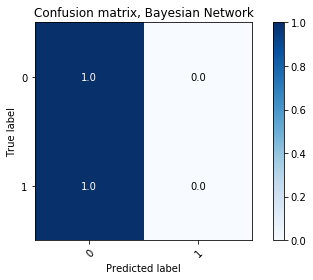

In [208]:
# Plot confusion matrix bayesian network
plot_confusion_matrix(np.asarray(y_true), np.asarray(y_pred), classes=np.asarray([0,1,2]),fname='bn.png',
                      title='Confusion matrix, Bayesian Network',normalize=True)


In [ ]:
a = plot_confusion_matrix(np.asarray(y), np.asarray(nb_y_pred), classes=np.asarray([0,1,2]),fname='nb.png',
                      title='Confusion matrix, Naive Bayes',normalize=True)


In [ ]:
plot_confusion_matrix(np.asarray(y), np.asarray(svm_y_pred), classes=np.asarray([0,1,2]),fname='svm.png',
                      title='Confusion matrix, SVM',normalize=True)

In [ ]:
plot_confusion_matrix(np.asarray(y), np.asarray(lr_y_pred), classes=np.asarray([0,1,2]),fname='lr.png',
                      title='Confusion matrix, Logistic Regression',normalize=True)

In [ ]:
network.structure

In [ ]:
!pip install pygraphviz

In [ ]:
#Viewing the DAG structure (need graphviz, pygraphviz)
network.plot()

In [ ]:
#unfortunate idiosyncrasy with saving: can't get the save to happen outside the exact current directory, so once
#you make the image you should move it to misc
network.plot('dag.pdf')

In [ ]:
#Random aside: If you wanted to know the final log likelihood of the data given the learned network, log P(D | G)
network.log_probability(train).sum()